# Face generator GAN

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import random

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchsummary import summary
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
seed = 999
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(False)

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [ ]:
RESUME_TRAINING = True

data_path = '/content/sample_data/img_align_celeba'
img_size = 64
batch_size = 128
latent_size = 100
img_channels = 3
num_channels = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 2e-4
lambda_gp = 10

epochs_list = [3, 2, 15]
critic_iters = [3, 1, 1]
gen_iters = [1, 1, 3]

assert len(epochs_list) == len(critic_iters)
assert len(critic_iters) == len(gen_iters)

print(device)

cuda:0


## Prepare Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataset = torch.utils.data.Subset(dataset, random.sample(range(len(dataset)), 50000))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Dataset size = {len(dataset)}')
print(f'Batch shape = {next(iter(dataloader))[0].shape}')

Dataset size = 50000
Batch shape = torch.Size([128, 3, 64, 64])


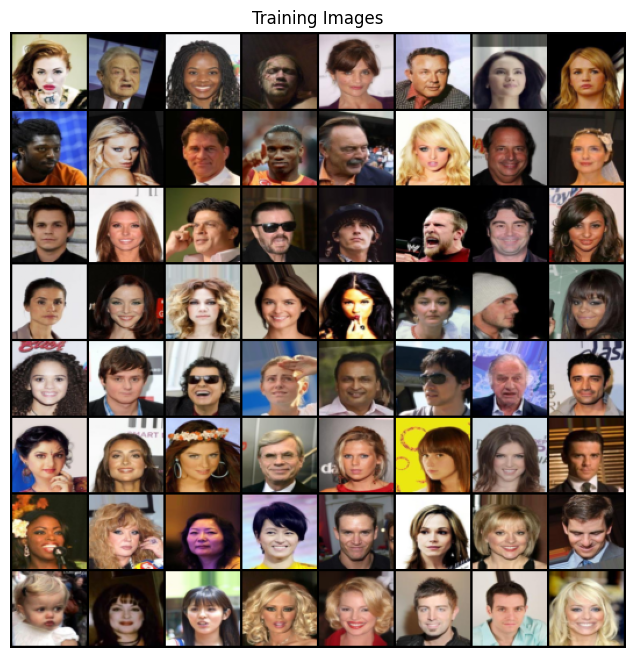

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Create Models

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, num_channels, img_channels):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.num_channels = num_channels
        self.img_channels = img_channels

        self.net = nn.Sequential(
            self._block(latent_size, 8*num_channels, 4, 1, 0),
            self._block(8*num_channels, 4*num_channels, 4, 2, 1),
            self._block(4*num_channels, 2*num_channels, 4, 2, 1),
            self._block(2*num_channels, num_channels, 4, 2, 1),
            nn.ConvTranspose2d(num_channels, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, add_norm=True):
        if add_norm:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.ReLU(True),
            )

    def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
class Critic(nn.Module):
    def __init__(self, img_channels, num_channels):
        super(Critic, self).__init__()
        self.img_channels = img_channels
        self.num_channels = num_channels

        self.net = nn.Sequential(
            self._block(img_channels, num_channels, 4, 2, 1, False),
            self._block(num_channels, 2*num_channels, 4, 2, 1, True),
            self._block(2*num_channels, 4*num_channels, 4, 2, 1, True),
            self._block(4*num_channels, 8*num_channels, 4, 2, 1, True),
            nn.Conv2d(8*num_channels, 1, kernel_size=1, stride=1, padding=0, bias=False),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, add_norm=True):
        if add_norm:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, x):
        x = self.net(x)
        # print(x.shape)
        return x

In [ ]:
generator = Generator(latent_size, num_channels, img_channels).to(device)
generator.apply(weights_init)
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
critic = Critic(img_channels, num_channels).to(device)
critic.apply(weights_init)
summary(critic, (img_channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 4, 4]             512
Total params: 2,757,888
Trainable params: 2,757,888
Non-trainable params: 0
---------------------------

In [ ]:
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=0ee507daca0b242ea7251ee53f2c514c982bdb963cdcb20989416be2dde8b234
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

y = generator(fixed_noise)
make_dot(y.mean(), params=dict(generator.named_parameters())).render("/content/sample_data/img", format="png")

'/content/sample_data/img.png'

In [ ]:
!pip install torchview

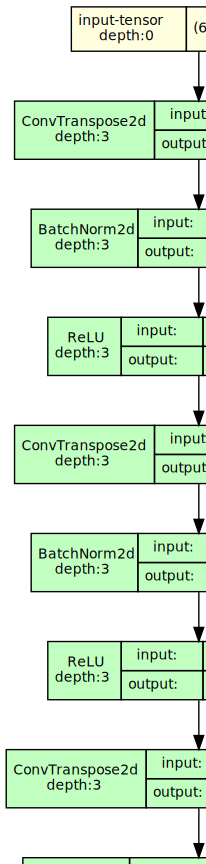

In [ ]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(Generator(latent_size, num_channels, img_channels), input_size=fixed_noise.shape, expand_nested=False)
model_graph.visual_graph

## Train Model

In [ ]:
def gradient_penalty(critic, real, fake):
    # print(real.shape)
    b, c, h, w = real.shape
    alpha = torch.rand((b, 1, 1, 1)).repeat(1, c, h, w).to(device)

    # calculate interpolated/mean images using random vector alpha and 1-alpha
    interpolated_images = real * alpha + fake * (1 - alpha)

    # calculate critic scores
    mixed_scores = critic(interpolated_images)

    # take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # reshape gradient to vector, calculate norm
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)

    # calculate gradient penalty
    gp = torch.mean((gradient_norm - 1) ** 2)

    return gp

def save_model(epoch):
    state = {
        'epoch': epoch+1,
        'generator': generator.state_dict(),
        'critic': critic.state_dict(),
        'opt_generator': opt_generator.state_dict(),
        'opt_critic': opt_critic.state_dict(),
    }

    torch.save(state, f'/content/sample_data/model_{epoch+1}.pt')

In [ ]:
assert(not RESUME_TRAINING)

img_list = []
critic_losses = []
gen_losses = []
gps = []
start_epoch = 0

total_epochs = sum(epochs_list)
for num_epochs, critic_iter, gen_iter in zip(epochs_list, critic_iters, gen_iters):
    end_epoch = start_epoch + num_epochs
    print(f'start_epoch = {start_epoch}, end_epoch = {end_epoch}, num_epochs = {num_epochs}')
    print(f'critic_iter = {critic_iter}, gen_iter = {gen_iter}')
    for epoch in range(start_epoch, end_epoch):
        for i, data in enumerate(dataloader, 0):

            # get current batch size and batch labels
            b_size = data[0].to(device).size(0)

            for _ in range(critic_iter):
                # reset gradients to zero
                critic.zero_grad()

                # Get critic output on real images
                real_images = data[0].to(device)
                real_output = critic(real_images).reshape(-1)
                # print(real_output.shape)

                # Get critic output on fake images
                noise = torch.randn(b_size, latent_size, 1, 1, device=device)
                fake_images = generator(noise)
                fake_output = critic(fake_images).reshape(-1)
                # print(fake_output.shape)

                # Calculate gradient penalty and critic loss
                gp = gradient_penalty(critic, real_images, fake_images)
                critic_loss = (
                    -(torch.mean(real_output) - torch.mean(fake_output)) + lambda_gp * gp
                )

                # Compute gradients and update Critic
                critic_loss.backward()
                opt_critic.step()

            for _ in range(gen_iter):
                # reset gradients to zero
                generator.zero_grad()

                # Calculate generator loss, compute gradients and update Generator
                fake_images = generator(noise)
                fake_output = critic(fake_images).reshape(-1)
                generator_loss = -torch.mean(fake_output)
                generator_loss.backward()
                opt_generator.step()

                # # generate new noise for next iteration
                noise = torch.randn(b_size, latent_size, 1, 1, device=device)


            if i % 50 == 0:
                print(f"Epoch: [{epoch}/{total_epochs}] Batch: {i}/{len(dataloader)} Loss D: {critic_loss.item()} Loss G: {generator_loss.item()} GP: {gp}")

            critic_losses.append(critic_loss.item())
            gen_losses.append(generator_loss.item())
            gps.append(gp)

        # save losses each epoch
        with open("/content/sample_data/losses.txt", 'a') as f:
            for c, g, gp in zip(critic_losses, gen_losses, gps):
              f.write(f'{c} {g} {gp}\n')
            critic_losses.clear()
            gen_losses.clear()
            gps.clear()

        # save generator output each epoch
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        if (epoch + 1) % 5 == 0 or epoch == sum(total_epochs) - 1:
          save_model(epoch)

    start_epoch = end_epoch

start_epoch = 0, end_epoch = 3, num_epochs = 3
critic_iter = 3, gen_iter = 1
Epoch: [0/20] Batch: 0/391 Loss D: 0.11492075026035309 Loss G: -0.15546095371246338 GP: 0.011106321588158607
Epoch: [0/20] Batch: 50/391 Loss D: -0.3812967538833618 Loss G: 0.18267416954040527 GP: 0.0029727602377533913
Epoch: [0/20] Batch: 100/391 Loss D: -0.16099488735198975 Loss G: 0.13230672478675842 GP: 0.002194065600633621
Epoch: [0/20] Batch: 150/391 Loss D: -0.20659708976745605 Loss G: 0.21489480137825012 GP: 0.0023530819453299046
Epoch: [0/20] Batch: 200/391 Loss D: -0.18521937727928162 Loss G: 0.20498552918434143 GP: 0.0017624644096940756
Epoch: [0/20] Batch: 250/391 Loss D: -0.26691392064094543 Loss G: 0.3424976170063019 GP: 0.002347234170883894
Epoch: [0/20] Batch: 300/391 Loss D: -0.18897056579589844 Loss G: 0.20724743604660034 GP: 0.0028403103351593018
Epoch: [0/20] Batch: 350/391 Loss D: -0.22487765550613403 Loss G: 0.3213672935962677 GP: 0.0030746697448194027
Epoch: [1/20] Batch: 0/391 Loss D: -

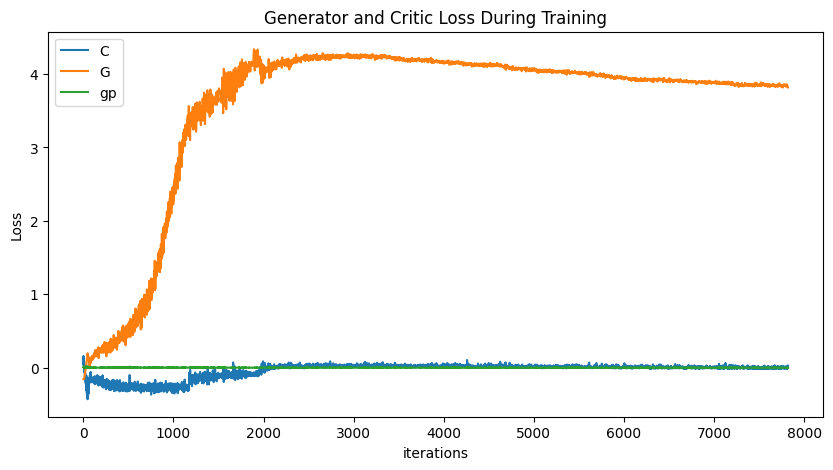

In [ ]:
with open("/content/sample_data/losses.txt", 'r') as f:
    for line in f:
        values = line.split(' ')
        critic_losses.append(float(values[0]))
        gen_losses.append(float(values[1]))
        gps.append(float(values[2]))

plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(critic_losses,label="C")
plt.plot(gen_losses,label="G")
plt.plot(gps, label="gp")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

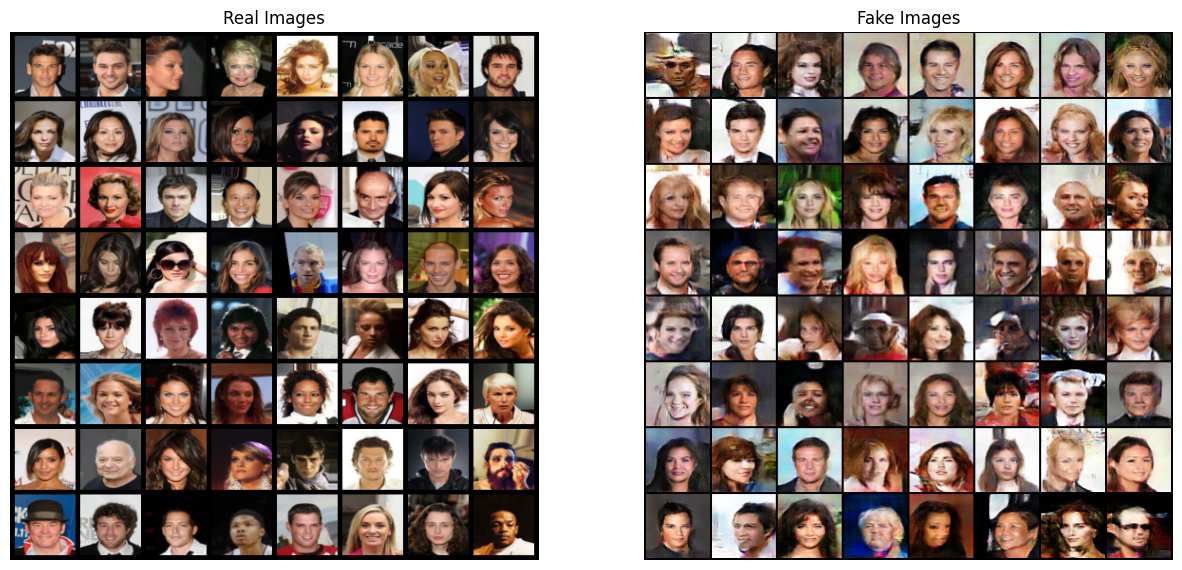

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Load Model and continue training

In [ ]:
assert(RESUME_TRAINING)
model_path = '/content/drive/MyDrive/Colab Notebooks/model_50.pt'
loss_path = '/content/drive/MyDrive/Colab Notebooks/losses.txt'

In [ ]:
state = torch.load(model_path)
critic.load_state_dict(state['critic'])
generator.load_state_dict(state['generator'])
opt_critic.load_state_dict(state['opt_critic'])
opt_generator.load_state_dict(state['opt_generator'])
start_epoch = state['epoch']

In [ ]:
img_list = []
critic_losses = []
gen_losses = []
gps = []

end_epoch = start_epoch + 10
critic_iter = 1
gen_iter = 5

for epoch in range(start_epoch, end_epoch):
    print(start_epoch, end_epoch)
    for i, data in enumerate(dataloader, 0):

        # get current batch size and batch labels
        b_size = data[0].to(device).size(0)

        for _ in range(critic_iter):
            # reset gradients to zero
            critic.zero_grad()

            # Get critic output on real images
            real_images = data[0].to(device)
            real_output = critic(real_images).reshape(-1)

            # Get critic output on fake images
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)
            fake_images = generator(noise)
            fake_output = critic(fake_images).reshape(-1)

            # Calculate gradient penalty and critic loss
            gp = gradient_penalty(critic, real_images, fake_images)
            critic_loss = (
                -(torch.mean(real_output) - torch.mean(fake_output)) + lambda_gp * gp
            )

            # Compute gradients and update Critic
            critic_loss.backward()
            opt_critic.step()

        for _ in range(gen_iter):
            # reset gradients to zero
            generator.zero_grad()

            # Calculate generator loss, compute gradients and update Generator
            fake_images = generator(noise)
            fake_output = critic(fake_images).reshape(-1)
            generator_loss = -torch.mean(fake_output)
            generator_loss.backward()
            opt_generator.step()

            # generate new noise for next iteration
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)


        if i % 50 == 0:
            print(f"Epoch: [{epoch}/{end_epoch}] Batch: {i}/{len(dataloader)} Loss D: {critic_loss.item()} Loss G: {generator_loss.item()} GP: {gp}")

        critic_losses.append(critic_loss.item())
        gen_losses.append(generator_loss.item())
        gps.append(gp)

    # save losses each epoch
    with open(loss_path, 'a') as f:
        for c, g, gp in zip(critic_losses, gen_losses, gps):
            f.write(f'{c} {g} {gp}\n')
        critic_losses.clear()
        gen_losses.clear()
        gps.clear()

    # save generator output each epoch
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    save_model(epoch)

50 60
Epoch: [50/60] Batch: 0/391 Loss D: 0.007519949227571487 Loss G: 3.682518482208252 GP: 0.0011895645875483751
Epoch: [50/60] Batch: 50/391 Loss D: 0.018177933990955353 Loss G: 3.6787610054016113 GP: 0.0013332075905054808
Epoch: [50/60] Batch: 100/391 Loss D: 0.003683095797896385 Loss G: 3.663984775543213 GP: 0.0009187704417854548
Epoch: [50/60] Batch: 150/391 Loss D: 0.024206986650824547 Loss G: 3.6436705589294434 GP: 0.00174964580219239
Epoch: [50/60] Batch: 200/391 Loss D: 0.007294049486517906 Loss G: 3.643203020095825 GP: 0.0010106672998517752
Epoch: [50/60] Batch: 250/391 Loss D: 0.002969544380903244 Loss G: 3.635666847229004 GP: 0.0007497112965211272
Epoch: [50/60] Batch: 300/391 Loss D: 0.018382862210273743 Loss G: 3.6110994815826416 GP: 0.0018232420552521944
Epoch: [50/60] Batch: 350/391 Loss D: -0.0013601873070001602 Loss G: 3.6081247329711914 GP: 0.0007979621877893806
50 60
Epoch: [51/60] Batch: 0/391 Loss D: 0.013800954446196556 Loss G: 3.605806589126587 GP: 0.0012722586

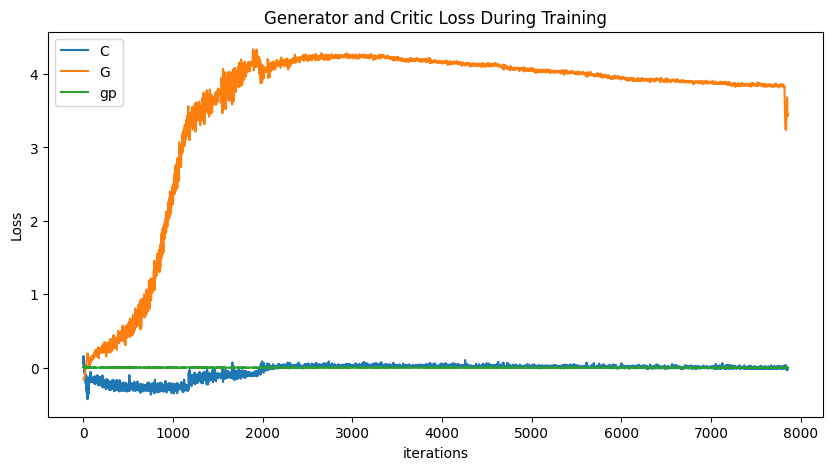

In [ ]:
with open(loss_path, 'r') as f:
    for line in f:
        values = line.split(' ')
        critic_losses.append(float(values[0]))
        gen_losses.append(float(values[1]))
        gps.append(float(values[2]))

plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(critic_losses,label="C")
plt.plot(gen_losses,label="G")
plt.plot(gps, label="gp")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

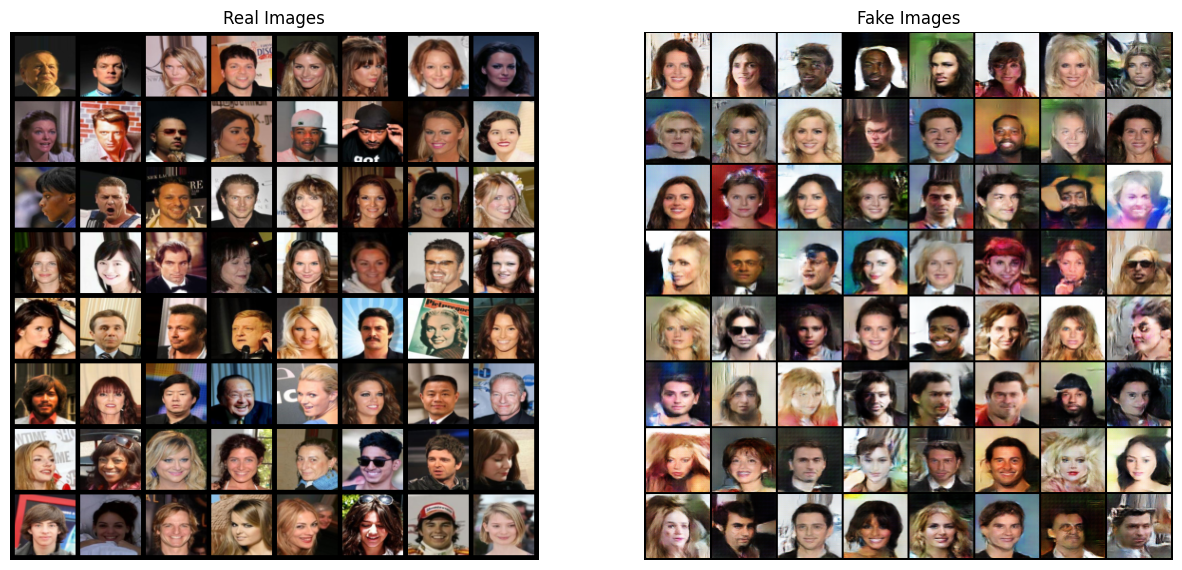

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Load Model and Generate Results

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/model_60.pt'
loss_path = '/content/drive/MyDrive/Colab Notebooks/losses.txt'

state = torch.load(model_path)
critic.load_state_dict(state['critic'])
generator.load_state_dict(state['generator'])
opt_critic.load_state_dict(state['opt_critic'])
opt_generator.load_state_dict(state['opt_generator'])
start_epoch = state['epoch']

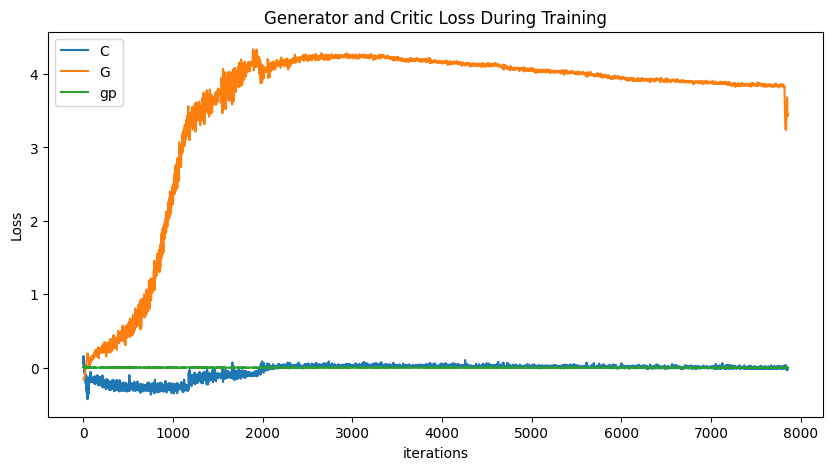

In [ ]:
critic_losses = []
gen_losses = []
gps = []

with open(loss_path, 'r') as f:
    for i, line in enumerate(f):
        values = line.split(' ')
        critic_losses.append(float(values[0]))
        gen_losses.append(float(values[1]))
        gps.append(float(values[2]))

plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(critic_losses,label="C")
plt.plot(gen_losses,label="G")
plt.plot(gps, label="gp")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

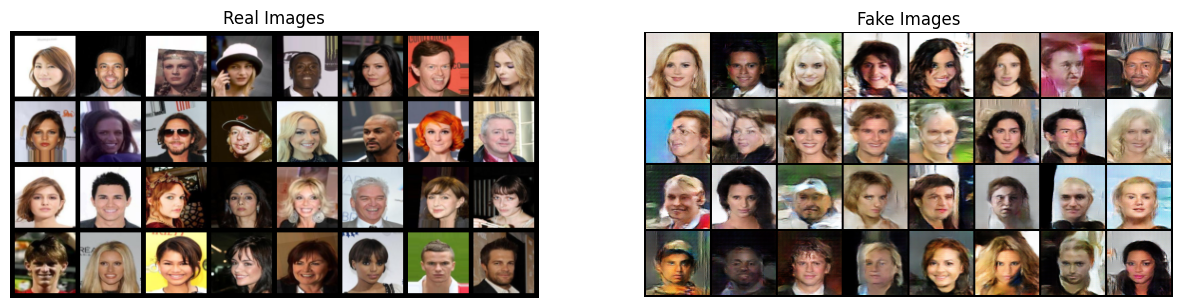

In [ ]:
img_list = []
no_of_images = 32
noise = torch.randn(no_of_images, latent_size, 1, 1, device=device)

# save generator output each epoch
with torch.no_grad():
    fake = generator(noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:no_of_images], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()